In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
import pickle as pckl
%matplotlib inline
sns.set_style("whitegrid")

import os

In [2]:
import sys
sys.path.append('../code/')
import make_genesets

In [4]:
#get good signature threshold
def create_good_geneset_matrix(bname='gdsc',abstype='_abs',rtype='_filtered'):
    datasets=['BEST_dorothea_AB','BEST_dorothea_CD','CGP','KEGG','BIOCARTA','REACTOME']
    scores=[]
    for fname in datasets:
        data=pd.read_csv('../results/benchmark/z_scores/%s/single/%s%s%s.csv' % (bname,fname,rtype,abstype),
                         sep=',',header=0,index_col=0)
        scores+=list(data.values.reshape((1,-1))[0])
    scores=np.array(scores)
    th=np.std(scores)*2.5
    for fname in datasets:
        data=pd.read_csv('../results/benchmark/z_scores/%s/single/%s%s%s.csv' % (bname,fname,rtype,abstype),
                         sep=',',header=0,index_col=0)
        data=(data.abs()>th)*1
        data.to_csv('../results/genesets/good/%s/%s%s%s.csv' % (bname,fname,rtype,abstype))

In [5]:
for bname in ['progeny','gdsc']:
    for abstype in ['','_abs']:
        for rtype in ['_filtered','_random']:
            create_good_geneset_matrix(bname,abstype,rtype) 

In [5]:
#write filterd gene sets to csv
datasets=['BEST_dorothea_AB','BEST_dorothea_CD','CGP','KEGG','BIOCARTA','REACTOME']
for dataset in datasets:
    make_genesets.make_pickle_from_genese(dataset+'_filtered')

In [6]:
#create overlap gene sets
datasets=['BEST_dorothea_AB','BEST_dorothea_CD','CGP','KEGG','BIOCARTA','REACTOME']
for dataset1 in datasets:
    for dataset2 in datasets:
        if dataset1<dataset2:
            make_genesets.make_overlap_gene_sets(dataset1+'_filtered',dataset2+'_filtered')

In [8]:
from subprocess import call

In [9]:
call(['Rscript','../code/make_viper_regulon_overlap.R'])

0

In [ ]:
call(['python3','../code/benchmark_progeny_overlap.py'])
call(['python3','../code/benchmark_gdsc_genomic_overlap.py'])

In [18]:
def merge_gene_sets(setname,fnames):
        setnames=[x for x in fnames if (setname in x)]
        data=pd.read_csv('../results/genesets/overlap/csvs/%s' % (setnames[0]),
                        sep=',',header=0,index_col=0)
        for s in setnames[1:]:
            new_data=pd.read_csv('../results/genesets/overlap/csvs/%s' % (s),
                        sep=',',header=0,index_col=0)
            data=pd.concat([data,new_data],0)
        data.to_csv('../results/genesets/overlap/csvs_final/%s.csv' % (setname),sep=',')

In [19]:
fnames=os.listdir('../results/genesets/overlap/csvs/')
datasets=['BEST_dorothea_AB','BEST_dorothea_CD','CGP','KEGG','BIOCARTA','REACTOME']
for dataset1 in datasets:
    for dataset2 in datasets:
        if dataset1<dataset2:
            setname=dataset1+'_filtered_overlap_'+dataset2+'_filtered'
            merge_gene_sets(setname,fnames)
        if dataset1!=dataset2:
            setname=dataset1+'_filtered_minus_'+dataset2+'_filtered'
            merge_gene_sets(setname,fnames)

            setname=dataset2+'_filtered_minus_'+dataset1+'_filtered'
            merge_gene_sets(setname,fnames)       

In [37]:
def merge_gene_set_scores(setname,fnames,benchmark):
        setnames=[x for x in fnames if (setname in x) & ~('_abs' in x)]
        data=pd.read_csv('../results/benchmark/rocaucs/%s/overlap/%s' % (benchmark,setnames[0]),
                        sep=',',header=0,index_col=0)
        for s in setnames[1:]:
            new_data=pd.read_csv('../results/benchmark/rocaucs/%s/overlap/%s' % (benchmark,s),
                        sep=',',header=0,index_col=0)
            data=pd.concat([data,new_data],1)
        data.to_csv('../results/benchmark/rocaucs/%s/overlap_final/%s.csv' % (benchmark,setname),sep=',')
            
            
        setnames=[x for x in fnames if (setname in x) & ('_abs' in x)]
        data=pd.read_csv('../results/benchmark/rocaucs/%s/overlap/%s' % (benchmark,setnames[0]),
                        sep=',',header=0,index_col=0)
        for s in setnames[1:]:
            new_data=pd.read_csv('../results/benchmark/rocaucs/%s/overlap/%s' % (benchmark,s),
                                    sep=',',header=0,index_col=0)
            data=pd.concat([data,new_data],1)
        data.to_csv('../results/benchmark/rocaucs/%s/overlap_final/%s_abs.csv' % (benchmark,setname),sep=',')

In [38]:
#merge small files to large ones
datasets=['BEST_dorothea_AB','BEST_dorothea_CD','CGP','KEGG','BIOCARTA','REACTOME']
for benchmark in ['progeny','gdsc']:
    fnames=os.listdir('../results/benchmark/rocaucs/%s/overlap/' % benchmark)
    for dataset1 in datasets:
        for dataset2 in datasets:
            if dataset1<dataset2:
                setname=dataset1+'_filtered_overlap_'+dataset2+'_filtered'
                merge_gene_set_scores(setname,fnames,benchmark)
            if dataset1!=dataset2:
                setname=dataset1+'_filtered_minus_'+dataset2+'_filtered'
                merge_gene_set_scores(setname,fnames,benchmark)

                setname=dataset2+'_filtered_minus_'+dataset1+'_filtered'
                merge_gene_set_scores(setname,fnames,benchmark)       

Normalise ROCAUCs.

In [40]:
results=pd.read_csv('../results/benchmark/rocaucs/gdsc/random_dist.csv',sep=',',header=0,index_col=0)
gdsc=pd.read_csv('../results/benchmark/datasets/gdsc_mut.csv',
                        sep=',',header=0,index_col=0)
gdsc=gdsc.sum(1)
gdsc=gdsc[results.index]
background=pd.DataFrame(index=results.index,columns=['Mean','Sd','Size'])
background['Mean']=np.mean(results,1)
background['Sd']=np.std(results,1)
background['Size']=gdsc

In [41]:
fnames=os.listdir('../results/benchmark/rocaucs/gdsc/overlap_final/')
try:
    fnames.remove('.DS_Store')
except:
    pass
data={}
for fname in fnames:
    data[fname[:-4]]=pd.read_csv('../results/benchmark/rocaucs/gdsc/overlap_final/'+fname,sep=',',header=0,index_col=0)
for method in data.keys():
    for pw in background.index:
        data[method].loc[pw,:]=(data[method].loc[pw,:]-0.5)/background.loc[pw,'Sd']
for method in data.keys():
    data[method].to_csv('../results/benchmark/z_scores/gdsc/overlap/%s.csv' % method, sep=',')

In [42]:
results=pd.read_csv('../results/benchmark/rocaucs/progeny/random_dist.csv',sep=',',header=0,index_col=0)
progeny=pd.read_csv('../results/benchmark/datasets/progeny_meta.csv',
                        sep=',',header=0,index_col=0)
progeny=progeny['pathway'].value_counts()
progeny=progeny[results.index]
background=pd.DataFrame(index=results.index,columns=['Mean','Sd','Size'])
background['Mean']=np.mean(results,1)
background['Sd']=np.std(results,1)
background['Size']=progeny

In [43]:
#normalise ROCAUCS
fnames=os.listdir('../results/benchmark/rocaucs/progeny/overlap_final/')
try:
    fnames.remove('.DS_Store')
except:
    pass
data={}
for fname in fnames:
    data[fname[:-4]]=pd.read_csv('../results/benchmark/rocaucs/progeny/overlap_final//'+fname,sep=',',header=0,index_col=0)
for method in data.keys():
    for pw in background.index:
        data[method].loc[pw,:]=(data[method].loc[pw,:]-0.5)/background.loc[pw,'Sd']
for method in data.keys():
    data[method].to_csv('../results/benchmark/z_scores/progeny/overlap/%s.csv' % method, sep=',')

test for one pair

In [52]:
dname1='CGP'
dname2='BIOCARTA'
bname='gdsc'
atype='_abs'

In [53]:
good1=pd.read_csv('../results/genesets/good/%s/%s_filtered%s.csv' % (bname,dname1,atype),
                 sep=',',header=0,index_col=0)
good2=pd.read_csv('../results/genesets/good/%s/%s_filtered%s.csv' % (bname,dname2,atype),
                 sep=',',header=0,index_col=0)

In [54]:
pathways=[]
good1set=[]
good2set=[]

In [55]:
for s1 in good1.columns:
    good_pathways=good1.index[good1[s1]==1]
    for pw in good_pathways:
        good2.columns[good2.loc[pw]==1]
        for pw in good_pathways:
            s2=list(good2.columns[good2.loc[pw]==1])
            n=len(s2)
            pathways+=[pw]*n
            good1set+=[s1]*n
            good2set+=s2
goods=pd.DataFrame(index=range(len(pathways)))
goods[dname1]=good1set
goods[dname2]=good2set
goods['Group']=pathways
if dname1<dname2:
    goods['Name']=goods[dname1]+'*'+goods[dname2]
else:
    goods['Name']=goods[dname2]+'*'+goods[dname1]


In [56]:
if dname1<dname2:
    score_overlap=pd.read_csv('../results/benchmark/z_scores/%s/overlap/%s_filtered_overlap_%s_filtered%s.csv' % (bname,dname1,dname2,atype),
                             sep=',',header=0,index_col=0).abs()
else:
    score_overlap=pd.read_csv('../results/benchmark/z_scores/%s/overlap/%s_filtered_overlap_%s_filtered%s.csv' % (bname,dname2,dname1,atype),
                             sep=',',header=0,index_col=0).abs()
score_1minus2=pd.read_csv('../results/benchmark/z_scores/%s/overlap/%s_filtered_minus_%s_filtered%s.csv' % (bname,dname1,dname2,atype),
                             sep=',',header=0,index_col=0).abs()
score_2minus1=pd.read_csv('../results/benchmark/z_scores/%s/overlap/%s_filtered_minus_%s_filtered%s.csv' % (bname,dname2,dname1,atype),
                             sep=',',header=0,index_col=0).abs()
score1=pd.read_csv('../results/benchmark/z_scores/%s/single/%s_filtered%s.csv' % (bname,dname1,atype),
                  sep=',',header=0,index_col=0).abs()
score2=pd.read_csv('../results/benchmark/z_scores/%s/single/%s_filtered%s.csv' % (bname,dname2,atype),
                  sep=',',header=0,index_col=0).abs()

In [57]:
goods.shape

(365745, 4)

In [58]:
all_sets=list(set(score_overlap.columns)&set(score_1minus2.columns)&set(score_2minus1.columns)&set(goods['Name']))

In [59]:
score_overlap=score_overlap[all_sets]
score_1minus2=score_1minus2[all_sets]
score_2minus1=score_2minus1[all_sets]
fil=np.in1d(goods['Name'],all_sets)
goods=goods[fil]

In [60]:
geneset1=pd.read_csv('../results/genesets/single/csvs/%s.csv' % dname1,sep=',',header=0,index_col=0)
geneset2=pd.read_csv('../results/genesets/single/csvs/%s.csv' % dname2,sep=',',header=0,index_col=0)
if dname1 < dname2:
    geneset_overlap=pd.read_csv('../results/genesets/overlap/csvs_final/%s_filtered_overlap_%s_filtered.csv' % (dname1,dname2),
                               sep=',',header=0,index_col=0)
else:
    geneset_overlap=pd.read_csv('../results/genesets/overlap/csvs_final/%s_filtered_overlap_%s_filtered.csv' % (dname2,dname1),
                               sep=',',header=0,index_col=0)
geneset_1minus2=pd.read_csv('../results/genesets/overlap/csvs_final/%s_filtered_minus_%s_filtered.csv' % (dname1,dname2),
                            sep=',',header=0,index_col=0)
geneset_2minus1=pd.read_csv('../results/genesets/overlap/csvs_final/%s_filtered_minus_%s_filtered.csv' % (dname2,dname1),
                            sep=',',header=0,index_col=0)


In [61]:
geneset1=geneset1['Set'].value_counts()
geneset2=geneset2['Set'].value_counts()
geneset_overlap=geneset_overlap['Set'].value_counts()
geneset_1minus2=geneset_1minus2['Set'].value_counts()
geneset_2minus1=geneset_2minus1['Set'].value_counts()

In [62]:
geneset1=geneset1[goods[dname1]].values
geneset2=geneset2[goods[dname2]].values
geneset_overlap=geneset_overlap[goods['Name']].values
geneset_1minus2=geneset_1minus2[goods['Name']].values
geneset_2minus1=geneset_2minus1[goods['Name']].values

In [63]:
results_genesets=pd.DataFrame(index=range(len(geneset_overlap)))
results_genesets[dname1]=geneset1
results_genesets[dname2]=geneset2
results_genesets[dname1+' & '+dname2]=geneset_overlap
results_genesets[dname1+' - '+dname2]=geneset_1minus2
results_genesets[dname2+' - '+dname1]=geneset_2minus1

In [64]:
row_index=pd.Series(range(len(score_overlap.index)),index=score_overlap.index)
col_index=pd.Series(range(len(score_overlap.columns)),index=score_overlap.columns)
score_overlap=score_overlap.values[list(row_index[goods['Group']].values),list(col_index[goods['Name']].values)]

row_index=pd.Series(range(len(score_1minus2.index)),index=score_1minus2.index)
col_index=pd.Series(range(len(score_1minus2.columns)),index=score_1minus2.columns)
score_1minus2=score_1minus2.values[list(row_index[goods['Group']].values),list(col_index[goods['Name']].values)]

row_index=pd.Series(range(len(score_2minus1.index)),index=score_2minus1.index)
col_index=pd.Series(range(len(score_2minus1.columns)),index=score_2minus1.columns)
score_2minus1=score_2minus1.values[list(row_index[goods['Group']].values),list(col_index[goods['Name']].values)]

row_index=pd.Series(range(len(score1.index)),index=score1.index)
col_index=pd.Series(range(len(score1.columns)),index=score1.columns)
score1=score1.values[list(row_index[goods['Group']].values),list(col_index[goods[dname1]].values)]

row_index=pd.Series(range(len(score2.index)),index=score2.index)
col_index=pd.Series(range(len(score2.columns)),index=score2.columns)
score2=score2.values[list(row_index[goods['Group']].values),list(col_index[goods[dname2]].values)]

In [65]:
results=pd.DataFrame(index=range(len(score_overlap)))
results[dname1]=score1
results[dname2]=score2
results[dname1+' & '+dname2]=score_overlap
results[dname1+' - '+dname2]=score_1minus2
results[dname2+' - '+dname1]=score_2minus1

In [66]:
results=pd.melt(results)
results_genesets=pd.melt(results_genesets)

In [67]:
results.columns=['Gene set','Informative score']
results_genesets.columns=['Gene set','Size']

In [68]:
results_all=pd.concat([results,results_genesets],1)

results_all.columns=['Set1','Score','Set2','Size']

In [69]:
import statsmodels.api as sm
from statsmodels.formula.api import ols


In [49]:
model=ols('Score ~ Set1 + Size',data=results_all[np.in1d(results_all['Set1'],[dname1+' - '+dname2,
                                                                            dname2+' - '+dname1])]).fit()

In [50]:
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
Set1,6.947037,1.0,5.882605,0.015507
Size,17.771100,1.0,15.048195,0.000113
Residual,964.832581,817.0,NaN,NaN


/Users/benceszalai/Library/Enthought/Canopy/edm/envs/Python3/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


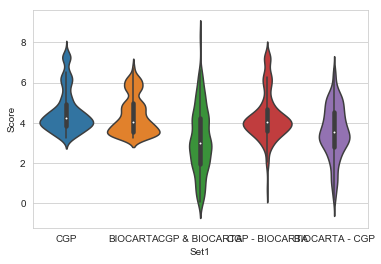

In [70]:
sns.violinplot(x='Set1',y='Score',data=results_all)

In [144]:
results_all['Set1'].unique()

array(['BEST_dorothea_AB', 'BIOCARTA', 'BEST_dorothea_AB & BIOCARTA',
       'BEST_dorothea_AB - BIOCARTA', 'BIOCARTA - BEST_dorothea_AB'],
      dtype=object)

In [114]:
results.shape

(1755, 2)

/Users/benceszalai/Library/Enthought/Canopy/edm/envs/Python3/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


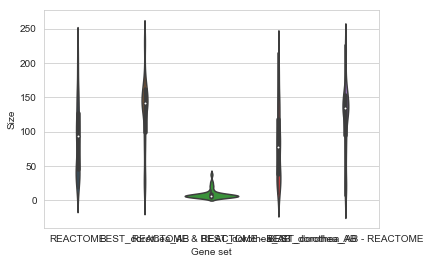

In [155]:
sns.violinplot(x='Gene set',y='Size',data=results_genesets)

In [39]:
results_genesets

,Gene set,Size
0,KEGG,57.0
1,KEGG,57.0
2,KEGG,57.0
3,KEGG,57.0
4,KEGG,57.0
5,KEGG,57.0
6,KEGG,57.0
7,KEGG,57.0
8,KEGG,57.0
9,KEGG,57.0


In [174]:
all_size=pd.DataFrame(columns=['Set','Size'])
all_scores=pd.DataFrame(columns=['Set','Score'])
datasets=['BEST_dorothea_AB','BEST_dorothea_CD','KEGG','BIOCARTA','REACTOME','CGP']
for geneset in datasets:
    size=pd.read_csv('../results/genesets/single/csvs/'+geneset+'_filtered.csv',sep=',',header=0,index_col=0)['Set'].value_counts()
    size=pd.DataFrame(size)
    size['X']=geneset
    size.columns=['Size','Set']
    size=size[['Set','Size']]
    all_size=pd.concat([all_size,size])
    score=pd.read_csv('../results/benchmark/z_scores/progeny/single/'+geneset+'_filtered.csv',
                   sep=',',header=0,index_col=0).abs().max()
    score=pd.DataFrame(score)
    score['X']=geneset
    score.columns=['Score','Set']
    score=score[['Set','Score']]
    all_scores=pd.concat([all_scores,score])

In [181]:
from scipy.stats import pearsonr as pcor
all_size=all_size.loc[all_scores.index]

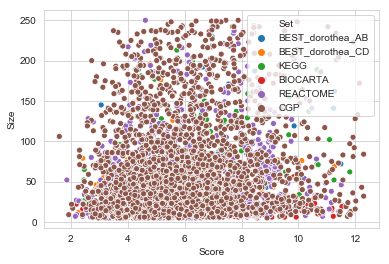

In [182]:
sns.scatterplot(all_scores['Score'],all_size['Size'],hue=all_scores['Set'])

In [183]:
pcor(all_scores['Score'],all_size['Size'])

(0.15267338896745478, 5.0354434826270335e-27)

In [179]:
all_scores.shape

(4916, 2)

In [180]:
all_size.shape

(5201, 2)